In [1]:
import re
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt

"""from dask.distributed import Client
from dask_ml import preprocessing
import dask.dataframe as dd
import dask.array as da"""

states = ["INITIAL","login","View_Items","home","logout","View_Items_quantity","Add_to_Cart","shoppingcart",
          "remove","deferorder","purchasecart","inventory","sellinventory","clearcart","cancelorder","$"]

#Data imports
PATH = "../../data/raw/"
sessions_file = (PATH+'sessions.dat')

# Load Session

In [2]:
def session_request_dict(sessions_file):
    s_r_dict = {}
    # Dict of sessions
    with open(sessions_file) as fn:
        sessions_raw = fn.readlines()

    for session in sessions_raw:
        key = re.search('([^.]+)', session).group()
        value = re.findall('\"(.*?)\"', session)
        s_r_dict[key] = value

    return s_r_dict

# Build and compute the transition matrix

In [4]:
def transition_matrix(sessions, states):
    markovchains = []

    for key, value in sessions.items():
        # labelEncoding
        le = preprocessing.LabelEncoder()
        le.fit(value)
        le.transform(value)

        # factorize
        factorize = pd.factorize(value)[0]
        
        # matrix
        n = 1 + max(factorize)  # number of states
        m = [[0] * n for _ in range(n)]

        for (i, j) in zip(factorize, factorize[1:]):
            m[i][j] += 1

        # now convert to probabilities:
        for row in m:
            s = sum(row)
            if s > 0:
                row[:] = [f / s for f in row]

        # unique array in the right order
        value = np.array(value)
        _, idx = np.unique(value, return_index=True)

        df = pd.DataFrame(data=m, index=value[np.sort(idx)],
                          columns=value[np.sort(idx)])

        df_1 = pd.DataFrame(index=states, columns=states, dtype='float64')
        df_1.update(df, join='left')

        merge = pd.concat([pd.concat([df_1, df], axis=1, sort=False)], axis=0).fillna(0).round(2).iloc[:, :-n]

        # convert into Vector
        merge = np.array(merge.values.flatten().tolist())
        # 2-D array
        markovchains.append(merge)
        # csr sparse matrix
        csr = csr_matrix(markovchains)

    return csr


## Split data into chunks

In [108]:
data = session_request_dict(sessions_file)

set_1 = {k: data[k] for k in list(data)[:1000]}
set_2 = {k: data[k] for k in list(data)[1000:3000]}

#print('load data done', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

# Cluster the chunks

In [109]:
X1 = transition_matrix(set_1, states)
X2 = transition_matrix(set_2, states)

#print('matrix done', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
#print('start clustering\n')

clustering1 = DBSCAN(eps=1.5, min_samples=10).fit(X1)
clustering2 = DBSCAN(eps=1.5, min_samples=10).fit(X2)

labels1 = clustering1.labels_
labels2 = clustering2.labels_
"""
print('LABELS 1:', np.unique(labels1, return_counts=True),'\n')
print('LABELS 1:', labels1,'\n')
print('LABELS 2:', np.unique(labels2, return_counts=True),'\n')
print('LABELS 2:', labels2,'\n')
"""
#print("End clustering", datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

"\nprint('LABELS 1:', np.unique(labels1, return_counts=True),'\n')\nprint('LABELS 1:', labels1,'\n')\nprint('LABELS 2:', np.unique(labels2, return_counts=True),'\n')\nprint('LABELS 2:', labels2,'\n')\n"

## Compare clustering results

Dictionary structure: key = No. of cluster, value = session per cluster

In [110]:
unique1, counts1 = np.unique(labels1, return_counts=True)
result1 = dict(zip(unique1, counts1))
unique2, counts2 = np.unique(labels2, return_counts=True)
result2 = dict(zip(unique2, counts2))
print(result1)
print(result2)

{0: 485, 1: 261, 2: 254}
{0: 515, 1: 1004, 2: 481}


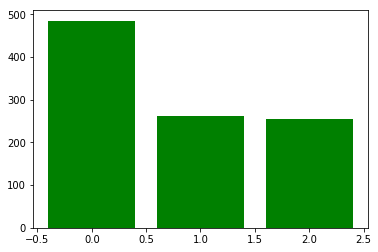

In [111]:
plt.bar(list(result1.keys()), result1.values(), color='g')
plt.show()

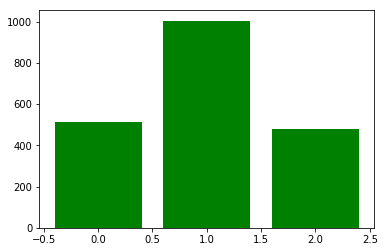

In [112]:
plt.bar(list(result2.keys()), result2.values(), color='g')
plt.show()

In [113]:
diff_dict = {}
for key in result1:
    if key in result2:
        diff_dict[key]=(result1[key]-result2[key])
        
if len(l1) != len(result2):
    for key in result2:
        if key not in result1.keys():
            diff_dict[key]=result2[key]

In [114]:
diff_dict

{0: -30, 1: -743, 2: -227}

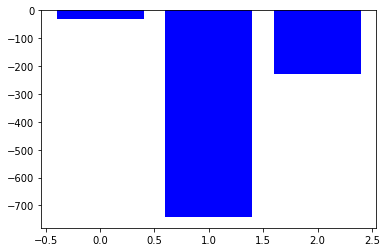

In [115]:
plt.bar(list(diff_dict.keys()), diff_dict.values(), color='b')
plt.show()